fetching dataset `elements` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements.pd.xz.
fetching dataset `elements_completed` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements_completed.pd.xz.
    MACHINE LEARNING INFORMATIONS    
-------------------------------------
Estimator       =  145
Max Depth       =  11
Max Features    =  15
R squared Test Data = 0.91128
R squared Train Data = 0.97773
-------------------------------------
       CROSS VALIDATION DATA         
-------------------------------------
Cross validation 1 = 0.9257953928758866
Cross validation 2 = 0.9390921818968339
Cross validation 3 = 0.9360137263735563
Cross validation 4 = 0.9317889171368902
Cross validation 5 = 0.8597303746415872
Cross validation 6 = 0.8642420168599196
Cross validation 7 = 0.9296513254090102
Cross validation 8 = 0.9284374033019824
Cross validation 9 = 0.8876930201991842
Cross validation 10 = 0.8587720601836297
Cross validation mean =  0.90612164

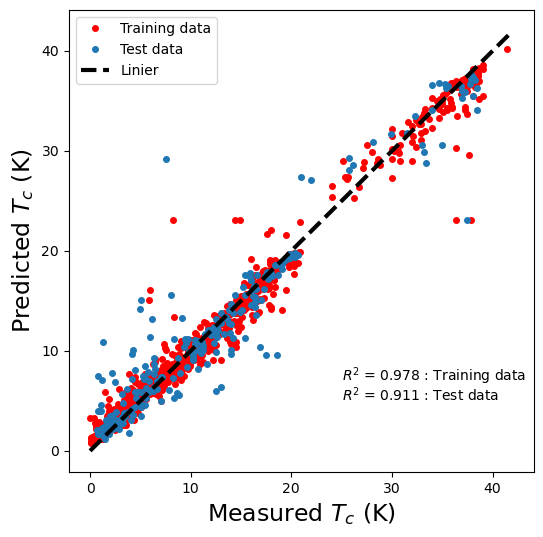

In [41]:
import pymatgen as pg
import pandas as pd
from xenonpy.descriptor import Compositions
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from sklearn.impute import SimpleImputer
from xenonpy.datatools import preset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn import preprocessing
from pymatgen.core.structure import Composition

preset.sync('elements')
preset.sync('elements_completed')
class Data_access():
    def __init__(self,file):
        self.file = file
    def __make_dic__(self,comp):
        return dict(Composition(comp).as_dict())
    def get_training_data(self):
        file = self.file
        if glob(file):
            dataset = pd.read_csv(file).copy()
        else:
            dataset =pd.DataFrame([file],columns = ["Compound"])
        data_com = dataset["Compound"].apply(self.__make_dic__).to_frame()
        cal = Compositions()
        features = cal.transform(data_com["Compound"])
        ######################remove nan ########################
        # features = features.replace([np.inf, -np.inf], np.nan)#
        # features = features.dropna(axis=1)                    #
        #########################################################
        X = features.copy()
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        new_data = imp.fit_transform(X)
        #data = preprocessing.StandardScaler().fit_transform(new_data)
        X = pd.DataFrame(new_data,columns = X.columns)
        if dataset.shape[1] > 1:
            return X, dataset["Tc"]
        else:
            return X

X,y = Data_access("Database.csv").get_training_data()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion="squared_error",
        max_depth=11, max_features=15, max_leaf_nodes=None,
        max_samples=None, min_impurity_decrease=0.0,min_samples_leaf=1,
        min_samples_split=2, min_weight_fraction_leaf=0.0,
        n_estimators=145, n_jobs=None, oob_score=False,
        random_state=42, verbose=0, warm_start=False)

rfr.fit(X_train,y_train)
score_rf_test = rfr.score(X_test,y_test)
score_rf_train = rfr.score(X_train,y_train)
hyperparameters = rfr.get_params()

print("=====================================")
print("    MACHINE LEARNING INFORMATIONS    ")
print("-------------------------------------")
print ("Estimator       = ", hyperparameters["n_estimators"])
print ("Max Depth       = ", hyperparameters["max_depth"])
print ("Max Features    = ", hyperparameters["max_features"])
print ("R squared Test Data =", str(round(score_rf_test,5)))
print ("R squared Train Data =", str(round(score_rf_train,5)))

cv_score = cross_val_score(rfr,
                X_train,
                y=y_train,
                groups=None,
                scoring=None,
                cv=10,
                n_jobs=4,
                verbose=0,
                fit_params=None,
                error_score=np.nan)


print("-------------------------------------")
print("       CROSS VALIDATION DATA         ")
print("-------------------------------------")
for fold in range(len(cv_score)):
    k_fold = (fold + 1)
    print ("Cross validation" + " " + str(k_fold) + " " + "=", cv_score[fold])
score_train=1 - np.abs(cv_score)
print ("Cross validation mean = ", cv_score.mean())

y_pred = rfr.predict(X_train)
print("-------------------------------------")
print("     Actual Tc VS Predicted Tc       ")
print("-------------------------------------")
df = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred})
df.to_csv('Training-data.csv', index=False)
print(df.head(5))

print("-------------------------------------")
print("      Descriptors contribution       ")
print("-------------------------------------")
coeff_df = pd.DataFrame(rfr.feature_importances_,X.columns,columns=['Coefficient'])
rank_score = coeff_df.sort_values(by='Coefficient', ascending=False)
rank_score.to_csv("Descriptor.csv", index=False)

descriptor = pd.read_csv("Descriptor.csv")
Data = []
column = X.columns.values
for col in range(len(column)):
    Data.append((column[col],descriptor["Coefficient"][col]))

desc_data = pd.DataFrame(Data,columns=['Descriptor','Coefficient'])
desc_data.to_csv('Descriptor-Coeff.csv', index=False)

print(coeff_df.head(5))

print("=====================================")
plt.figure(figsize=(6, 6))
plt.plot(y_train,rfr.predict(X_train),"o",color = "red",  markersize = 4, label = "Training data")
plt.plot(y_test,rfr.predict(X_test),"o", markersize = 4, label ="Test data")
plt.xlabel("Measured $\it{T_c}$ (K)", fontsize=17)
plt.ylabel("Predicted $\it{T_c}$ (K)",fontsize=17)
plt.text(25,5, "$\it{R}^{2}$ = " + str(round(score_rf_test,3))  + " : Test data",fontsize=10)
plt.text(25,7, "$\it{R}^{2}$ = " + str(round(score_rf_train,3)) + " : Training data",  fontsize=10)
x_axis = np.linspace(0, 42, 5)
plt.plot(x_axis, x_axis, label='Linier', color='black', linewidth = 3, linestyle='--')
plt.legend()
plt.show()

In [15]:
cross_val_score?